### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

# Packages

In [1]:
from os.path import isdir
from os import mkdir

env = 'colab'  # 'pc', 'colab'
git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Semi-Supervised-Labelling/master/'
experiment = 'Exp5000Randomized/'

save_dir = ''
if env == 'pc':
    save_dir = f'C:/Users/79137/Pasha/2. UNIPD/Semester 2/Optimization for Data Science/Homeworks/HW 1/Semi-Supervised-Labelling/'
elif env == 'colab':
    save_dir = f'/content/drive/MyDrive/UNIPD/ODS/HW1/'

In [2]:
%%capture

def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    files = [
           'BCGDSolver.py',
           'DataProperties.py',
           'GradientDescentSolver.py',
           'GradientSolver.py',
           'Utils.py'  
    ]

    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

# Saving directory

In [3]:
full_dir = f'{save_dir}{experiment}'
assert(isdir(save_dir))

if not isdir(full_dir):
    mkdir(full_dir)

assert(isdir(full_dir))

In [4]:
from sklearn.datasets import make_blobs
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
import timeit

# Plotting
import matplotlib.pyplot as plt

In [5]:
import Utils
import GradientSolver
import GradientDescentSolver
import DataProperties
import BCGDSolver
import importlib

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        Utils,
        GradientSolver,
        GradientDescentSolver,
        DataProperties,
        BCGDSolver
    ]
)

from Utils import *
from GradientSolver import GradientSolver
from GradientDescentSolver import GradientDescentSolver
from DataProperties import DataProperties
from BCGDSolver import BCGDSolver

# Data preparation

In [6]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

np.random.seed(numpy_seed)

In [7]:
# %%timeit
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state,
    cluster_std = 1.5
)


def euclidian_similarity(Xi, Xj):
    return 1 / (norm(Xi - Xj) + 0.001)

In [8]:
# %%timeit

# Old inefficient weights calculation
# weights = calc_weight_matrix(X, weight_func = None)

from sklearn.metrics import pairwise_distances

weights = pairwise_distances(X, metric = 'euclidean')
weights = 1 / (weights + 0.001)
assert(weights.shape == (DataProperties.n_samples, DataProperties.n_samples))

Data shape: X: (5000, 2), Y: (5000,)


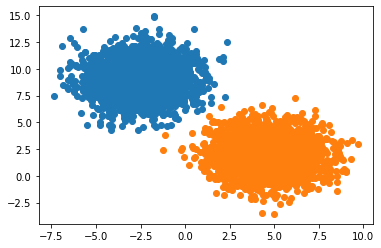

In [9]:
Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')
plot_clusters(X, Y)

## Unlabel subset and visualize

Found 2500 instances of object 0.0
We have to delabel 2375 instances
Found 2500 instances of object 1.0
We have to delabel 2375 instances

    We have 4750 unlabeled data
    Out of 5000
    


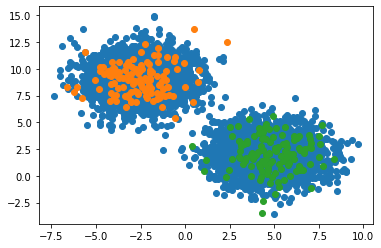

In [10]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

plot_clusters(X, Y_delabeled)

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [11]:
import collections
class_stats = collections.Counter(Y_delabeled)
assert(len(class_stats.keys()) == 3)  # 2 labeled classes and 1 unlabeled
print(class_stats)

Counter({-1000000.0: 4750, 1.0: 125, 0.0: 125})


# Gradient descent

In [ ]:
solver = GradientDescentSolver(
    similarity_func = None, # euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.0001
)

In [ ]:
Y_preds_GD = solver.solve(
    X, 
    Y_delabeled,
    Y_true = Y,
    iter_limit = 30,
    delta_percent_limit = 0.1,  # when dLoss / dLoss prev < 0.02
    delta_loss_limit = 0.0, # dont use
    stop_loss = 0.0,  # dont use
    weight_matrix = weights
)

Iteration: 0, Loss: 102822.87984855211, delta loss: 102822.87984855211
Iteration: 1, Loss: 100919.57359918414, delta loss: -1903.3062493679754
Iteration: 2, Loss: 99477.47817240715, delta loss: -1442.0954267769848
Iteration: 3, Loss: 98371.39359619911, delta loss: -1106.0845762080426


KeyboardInterrupt: ignored

Accuracy: 1.0


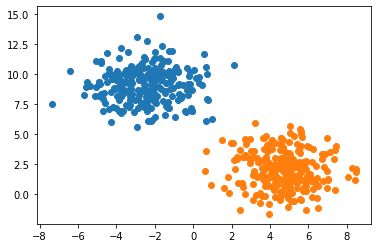

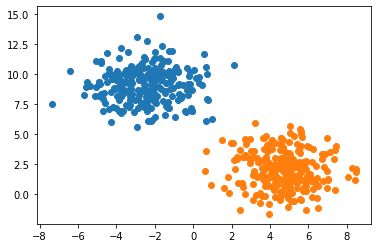

In [ ]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_GD)
print(f'Accuracy: {accuracy_score(Y, Y_preds_GD)}')

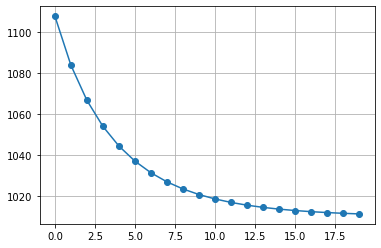

In [ ]:
plt.plot(solver.losses, marker = 'o')
plt.grid()

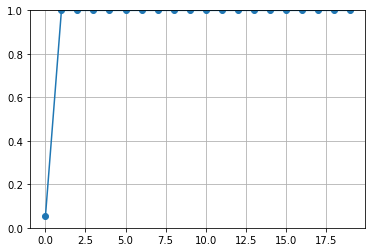

In [ ]:
plt.plot(solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

# Block coordinates gradient descent (randomized)

## BCGD random permutations

In [ ]:
random_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.0001,
    similarity_func = None,

    bcgd_strategy = 'random permutation',
)

In [ ]:
Y_preds_BCGD_permutation = random_solver.solve(
    X, 
    Y_delabeled, 
    Y_true = Y,
    iter_limit = 30,
    delta_percent_limit = 0.1,  # when dLoss / dLoss prev
    delta_loss_limit = 0.0,
    stop_loss= 0.0,
    weight_matrix = weights
)

Iteration: 0, Loss: 102822.87984855211, Delta: 102822.87984855211
Iteration: 1, Loss: 100677.53041786962, Delta: 2145.349430682487
Iteration: 2, Loss: 99115.62048110875, Delta: 1561.9099367608724
Iteration: 3, Loss: 97962.79580855397, Delta: 1152.8246725547797
Iteration: 4, Loss: 97103.77145155089, Delta: 859.0243570030871
Iteration: 5, Loss: 96459.35666391515, Delta: 644.414787635731
Iteration: 6, Loss: 95973.50432485607, Delta: 485.85233905908535
Iteration: 7, Loss: 95605.88972872205, Delta: 367.6145961340226


KeyboardInterrupt: ignored

Accuracy: 1.0


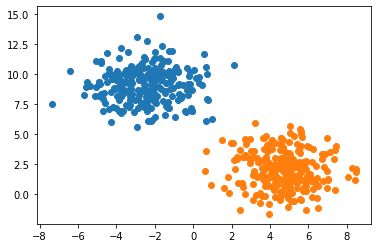

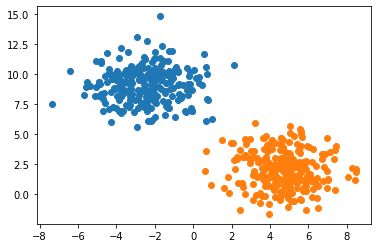

In [ ]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_BCGD_permutation)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_permutation)}')

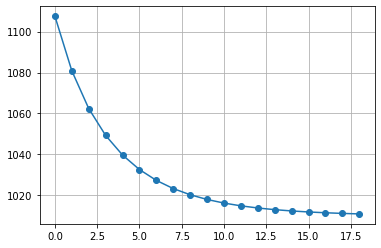

In [ ]:
plt.plot(random_solver.losses, marker = 'o')
plt.grid()

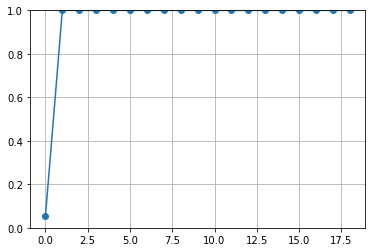

In [ ]:
plt.plot(random_solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

## BCGD random sampling

In [14]:
BCGD_RS_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.0001,
    similarity_func = None,
    bcgd_strategy = 'random sampling'
)

In [15]:
Y_preds_BCGD_sampling = BCGD_RS_solver.solve(
    X = X, 
    Y = Y_delabeled,
    Y_true = Y,
    iter_limit = 30, #  * len(Y_delabeled[Y_delabeled == DataProperties.unlabeled]),
    delta_loss_limit = 0.0,
    delta_percent_limit = 0.0,  # when dLoss / dLoss prev
    stop_loss= 0,
    weight_matrix = weights
)

Iteration: 0, Loss: 102822.87984855211, Delta: 102822.87984855211
Iteration: 1, Loss: 102822.60405919357, Delta: 0.2757893585367128
Iteration: 2, Loss: 102822.32239734591, Delta: 0.28166184766450897
Iteration: 3, Loss: 102821.49011027774, Delta: 0.8322870681731729
Iteration: 4, Loss: 102820.68714709028, Delta: 0.8029631874524057


KeyboardInterrupt: ignored

Accuracy: 0.552


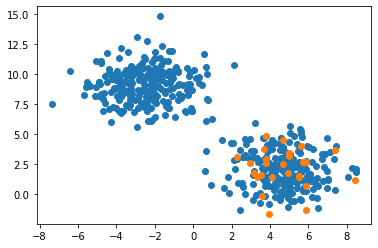

In [ ]:
plot_clusters(
    X, Y_preds_BCGD_sampling
)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_sampling)}')

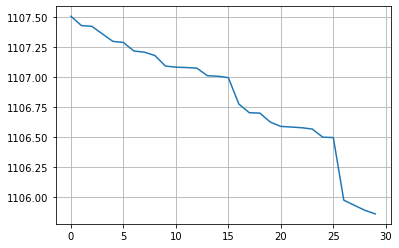

In [ ]:
plt.plot(BCGD_RS_solver.losses)
plt.grid()

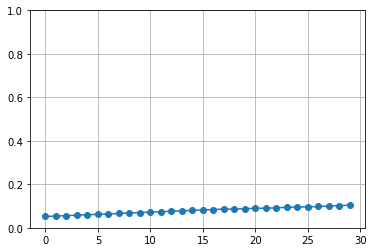

In [ ]:
plt.plot(BCGD_RS_solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

## BCGD cyclic

In [ ]:
BCGD_cyclic_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.0001,
    similarity_func = None,
    bcgd_strategy = 'cyclic'
)

In [ ]:
Y_preds_BCGD_cyclic = BCGD_cyclic_solver.solve(
    X,
    Y_delabeled, 
    Y_true = Y,
    iter_limit = 30, 
    delta_percent_limit = 0.10,  # when dLoss / dLoss prev
    delta_loss_limit = 0.0,
    stop_loss = 0,
    weight_matrix = weights
)

Iteration: 0, Loss: 102822.87984855211, Delta: 102822.87984855211
Iteration: 1, Loss: 100677.4925230569, Delta: 2145.387325495205


KeyboardInterrupt: ignored

Accuracy: 1.0


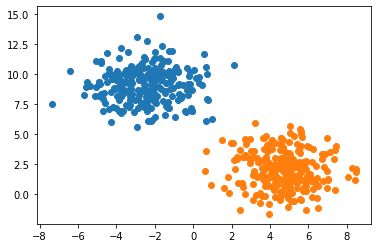

In [ ]:
print(f'Accuracy: {accuracy_score(Y_preds_BCGD_cyclic, Y)}')
plot_clusters(
    X, Y_preds_BCGD_cyclic
)

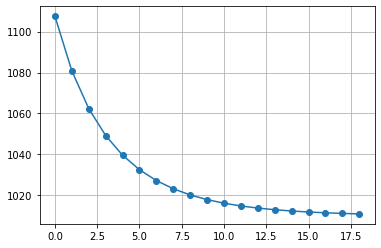

In [ ]:
plt.plot(BCGD_cyclic_solver.losses, marker = 'o')
plt.grid()

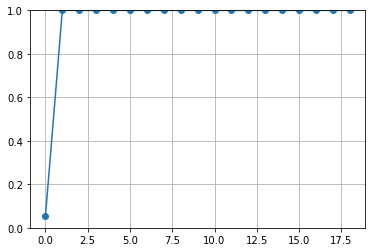

In [ ]:
plt.plot(BCGD_cyclic_solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

# Model comparison

We will compare models based on:
- Clustering metrics
- CPU time
- Number of iterations
- Loss curves
- Distance metrics

In [16]:
learning_rate_strategy = 'lr_constant'
simil_func = None  # No feature yet
lr = 0.0001

gd_solver = GradientDescentSolver(
    similarity_func = simil_func,
    lr_strategy = learning_rate_strategy,
    learning_rate = lr
)

bcgd_permut_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random permutation',
)

bcgd_sampling_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random sampling',
)

bcgd_cyclic_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'cyclic',
)

solvers = {
    # 'GD': gd_solver,
    # 'BCGD permutation': bcgd_permut_solver,
    # 'BCGD cyclic': bcgd_cyclic_solver,
    'BCGD sampling': bcgd_sampling_solver,
}

In [17]:
def compare_models(solvers_dict, X, Y_true, Y_delabeled, iters_limit, delta_percent_limit, delta_loss_limit, stop_loss, weights_matrix):
    predictions = {k:None for k in solvers_dict.keys()}
    losses = {k:None for k in solvers_dict.keys()}
    n_iterations = {k:None for k in solvers_dict.keys()}
    cpu_times_total = {k:None for k in solvers_dict.keys()}

    for model_name, model in solvers_dict.items():
        print(f'Fitting {model_name}')
        start = timeit.default_timer()
        Y_preds = model.solve(
            X,
            Y_delabeled,
            Y_true = Y_true,
            iter_limit = iters_limit,
            delta_percent_limit = delta_percent_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss= stop_loss,
            weight_matrix = weights_matrix
        )
        end = timeit.default_timer()
        predictions[model_name] = Y_preds
        losses[model_name] = model.losses
        n_iterations[model_name] = model.n_iterations
        cpu_times_total[model_name] = end - start
    

    return predictions, losses, n_iterations, cpu_times_total

In [19]:
iters_limit = 50
delta_loss_limit = 0.0  # we dont use it anymore
stop_loss= 0  # we dont use it anymore
delta_percent_limit = 0,  # when dLoss / dLoss prev


preds, losses, n_iters, cpu_times_total = compare_models(
        solvers,
        X,
        Y_delabeled = Y_delabeled,
        Y_true = Y,
        iters_limit = iters_limit,
        delta_percent_limit = delta_percent_limit,
        delta_loss_limit = delta_loss_limit,
        stop_loss = stop_loss,
        weights_matrix =  weights
    )

Fitting BCGD sampling
Iteration: 0, Loss: 102822.87984855211, Delta: 102822.87984855211
Iteration: 1, Loss: 102822.3430521119, Delta: 0.5367964402103098
Iteration: 2, Loss: 102822.23290044357, Delta: 0.11015166832657997
Iteration: 3, Loss: 102821.90601583854, Delta: 0.3268846050341381
Iteration: 4, Loss: 102821.50578733964, Delta: 0.4002284988964675
Iteration: 5, Loss: 102821.27908595961, Delta: 0.22670138003013562
Iteration: 6, Loss: 102820.67135148788, Delta: 0.6077344717341475
Iteration: 7, Loss: 102820.50406669514, Delta: 0.1672847927402472
Iteration: 8, Loss: 102820.45604232131, Delta: 0.04802437382750213
Iteration: 9, Loss: 102820.09908320515, Delta: 0.35695911616494413
Iteration: 10, Loss: 102820.08427356482, Delta: 0.014809640328167006
Iteration: 11, Loss: 102819.58108961578, Delta: 0.503183949040249
Iteration: 12, Loss: 102818.99276383652, Delta: 0.5883257792593213
Iteration: 13, Loss: 102818.61524862605, Delta: 0.37751521046448033
Iteration: 14, Loss: 102818.3090851581, Delta

In [20]:
accuracies = {name: solver.accuracies for name, solver in solvers.items()}
cpu_times = {name: solver.cpu_times for name, solver in solvers.items()}

## Saving data

In [21]:
# iters_limit = 17
# delta_loss_limit = 0.0001
# stop_loss= 21000  # 4000

experiment_params = pd.DataFrame(
    {
        'iters_limit': [iters_limit],
        'd_loss_limit': [delta_loss_limit],
        'delta_percent_limit': [delta_percent_limit],
        'stop_loss': [stop_loss],
        'learning_rate': [lr],
        'n points': [DataProperties.n_samples]
    },
    # index = False
)

experiment_params.to_csv(full_dir + 'experiment_params.csv')
experiment_params.head()

,iters_limit,d_loss_limit,delta_percent_limit,stop_loss,learning_rate,n points
0,50,0.0,"(0,)",0,0.0001,5000


In [22]:
results = pd.DataFrame()

# fill losses
for model_name, loss in losses.items():
    new = pd.DataFrame({f'{model_name} loss': loss})
    results = pd.concat([results, new], axis = 1)
    # results[f'{model_name} loss'] = loss

for model_name, cpu_time in cpu_times.items():
    new = pd.DataFrame({f'{model_name} cpu': cpu_time})
    results = pd.concat([results, new], axis = 1)
    # results[f'{model_name} cpu'] = cpu_time

for model_name, acc in accuracies.items():
    new = pd.DataFrame({f'{model_name} acc': acc})
    results = pd.concat([results, new], axis = 1)


results.to_csv(full_dir + 'res.csv')
results.head()

,BCGD sampling loss,BCGD sampling cpu,BCGD sampling acc
0,102822.879849,31.829252,0.0500
1,102822.343052,63.475447,0.0502
2,102822.232900,95.545339,0.0504
3,102821.906016,127.995053,0.0506
4,102821.505787,160.394915,0.0508


,CPU total time,N iterations,Final accuracy,CPU total time_norm,N iterations_norm,Final accuracy_norm
BCGD sampling,1608.342744,50,0.0596,1.0,1.0,1.0


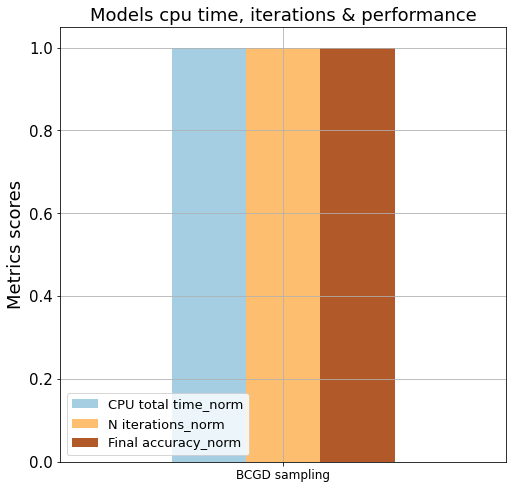

In [23]:
bar_metrics = pd.DataFrame.from_dict(cpu_times_total, orient='index', columns = ['CPU total time'])
bar_metrics['N iterations'] = n_iters.values()

final_accuracies = {name: acc[-1] for name, acc in accuracies.items()}
bar_metrics['Final accuracy'] = final_accuracies.values()



normalize_cols(bar_metrics)
cols_to_plot = [c for c in bar_metrics.columns if 'norm' in c]

plot_bar_metrics(bar_metrics.loc[:, cols_to_plot])
bar_metrics.to_csv(full_dir + 'metrics res.csv')

bar_metrics.head()

## Graphics

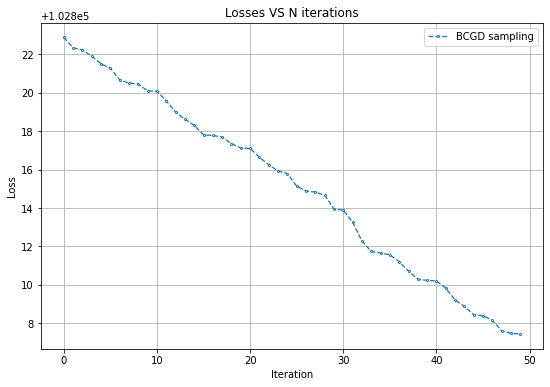

In [24]:
def plot_curves(curves_dict, title, y_label, figsize):
    _, ax = plt.subplots(figsize = figsize)

    for _, curve_res in curves_dict.items():
        ax.plot(
            curve_res,
            marker = 'o',
            linestyle = '--',
            linewidth = 1.3,
            markerfacecolor = 'white',
            markersize = 2
        )
    plt.legend(list(curves_dict.keys()))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.grid()


# plot_curves({'Cyclic':losses['BCGD cyclic']}, 'Losses cyclic', y_label = 'Loss')
# plot_curves({'GD':losses['GD']}, 'Losses GD', y_label = 'Loss')
plot_curves(
    losses,
    'Losses VS N iterations', 
    y_label = 'Loss',
    figsize = (9, 6)
)

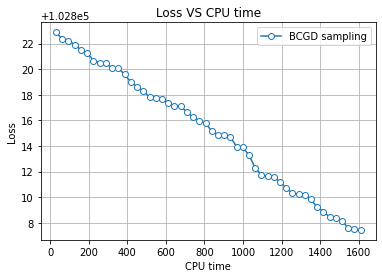

In [25]:
def plot_losses_vs_cpu(losses_, cpu_times_):
    assert(list(losses_.keys()) == list(cpu_times_.keys()))

    _, ax = plt.subplots()

    for model_name, loss in losses_.items():
        cpu_time = cpu_times_[model_name]

        ax.plot(
            cpu_time,
            loss,
            marker = 'o',
            markerfacecolor = 'white'
        )
    plt.xlabel('CPU time')
    plt.ylabel('Loss')
    plt.title('Loss VS CPU time')
    plt.legend(list(losses_.keys()))
    plt.grid()


plot_losses_vs_cpu(losses, cpu_times)

# Real dataset

In [ ]:
# df = pd.read_csv('Pokemon.csv')

In [ ]:
# df.head()

,number,name,type1,type2,total,hp,attack,defense,sp_attack,sp_defense,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,3,Gigantamax Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


In [ ]:
# df.head()
# X_real = df.loc[:, ['total', 'sp_attack']].values
# Y_real = df['legendary'].astype('int').values


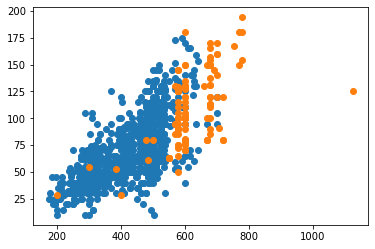

In [ ]:
# plot_clusters(
#     X_real,
#     Y_real
# )

In [ ]:
# Y_real_delabeled = delabel_data(
#     Y_real,
#     labeled_percent = 0.16, # DataProperties.labeled_percentage,
#     delabel_value = DataProperties.unlabeled
# )

Found 954 instances of object 0
We have to delabel 801 instances
Found 118 instances of object 1
We have to delabel 99 instances


In [ ]:
# wine=datasets.load_wine()

# #Conver to pandas dataframe
# data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

# data = data.loc[
#     (data['target'] == 1) | (data['target'] == 0),
#     ['od280/od315_of_diluted_wines', 'alcohol', 'target']
# ]

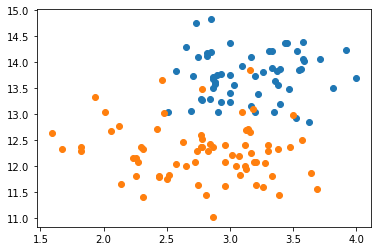

In [ ]:
# X_real = data.loc[
#     :,
#     ['od280/od315_of_diluted_wines', 'alcohol']
# ].values
# Y_real = data['target'].values

# plot_clusters(
#     X_real,
#     Y_real
# )

In [ ]:
# solver = GradientDescentSolver(
#     lr_strategy = 'lr_constant',
#     learning_rate = 0.0001,
#     similarity_func = None
# )

# Y_real_preds = solver.solve(
#     X_real,
#     Y_real_delabeled,
#     iter_limit=5,
#     delta_loss_limit = 0.003,
#     stop_loss = 20
# )

Iteration: 0, Loss: 24173.807351957803, delta loss: 24173.807351957803
Iteration: 1, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 2, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 3, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 4, Loss: 24173.807351957803, delta loss: 0.0


